# Libraries

In [1]:
%pylab inline
import Tools.ext as Te
import Tools.display as Td
import Tools.matrices as Tm
import Tools.functions as Tf
import Connectomes_Jonathan as Cj
import pandas as pd
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


# Loading

In [2]:
dir_86 = '../../../TimeCourses/Jonathan/86/'
dir_512 = '../../../TimeCourses/Jonathan/512/'
dir_nEEG = '../../../TimeCourses/Jonathan/86_noEEG/'
Reg0 = 'grey_matter_sansSB_sansLCR/'
Reg1 = 'grey_matter_sansSB_sansLCR_sansGlobMean/'

In [3]:
cen86 = Te.data2array('../../../Connectomes/Jonathan/86/centres/t10.txt')
or86 = Te.data2array('../../../Connectomes/Jonathan/ReorderByHemi86.txt').astype(int)[0]
dow = Te.data2array('../../../Connectomes/Jonathan/AAL512_to_AAL86.txt')[0].astype(int)
lbl = Te.data2array('../../../Connectomes/Jonathan/AAL.npy', dic=1)
MHub = Te.data2array('./MDFC/clus_indices.npy', dic=1)

In [4]:
LBL = [lbl[k] for k in sorted(lbl.keys())]

In [5]:
KS1 = sorted([k.rstrip('.txt') for k in Te.os.listdir(dir_86 + Reg0)])
KS2 = sorted([k.rstrip('.txt') for k in Te.os.listdir(dir_nEEG + Reg0)])

In [6]:
TC = {'86u':{},'86r':{},'512u':{},'512r':{}}
for typ, di, sub in [['86u',  dir_86,   Reg0], ['86r',  dir_86,   Reg1],
                     ['512u', dir_512,  Reg0], ['512r', dir_512,  Reg1]]:
    for k in KS1:
        TC[typ][k] = Te.data2array(di + sub + k + '.txt', finite=True).T

# Dynamical Functional Connectivity

In [ ]:
# 5h30
Td.tic()
rN = arange(512)
for w in range(4,31):
    for typ in TC.keys():
        N = int(typ[:-1])
        if N == 512:
            for R in range(86):
                try:    
                    Te.data2array('./DFCs/win_%i_typ_%s_ROI_%i.npy'%(w,typ,R), dic=1)
                except: 
                    to_save = {}
                    Ns = rN[dow == R]
                    n = len(Ns)
                    iA = arange( n*N ).reshape((n, N))
                    iD = iA[xrange(n), Ns]
                    iNs = setdiff1d(iA, iD)

                    for k in KS1:
                        FCs = Tf.windowedFCs(TC[typ][k].T, window=w, nodes=Ns)
                        to_save[k] = Tf.fPearsonCorrelation(FCs.reshape((len(FCs), n*N)).T[iNs])
                        del FCs

                    Te.array2data(to_save, './DFCs/win_%i_typ_%s_ROI_%i.npy'%(w,typ,R))
                    del to_save

In [7]:
# 6h40-12 H ?
# S[dim] = [regression] x [patients/controls + p_val] x [ROI] x [w] x [tau] x [metric]
try:
    S = Te.data2array('DFCs/S6D.npy')
except:
    S = zeros((2, 21+1, 86, 27, 57, 3))

    Td.tic()
    for ir, r in zip([0,1], ['u','r']):
        typ = '512'+r

        for R in xrange(86):
            for iw, w in zip(xrange(27), xrange(4,31)):
                if (S[ir, :, R, iw, :, :] == zeros((22,57,3))).all():
                    DFC = Te.data2array('./DFCs/win_%i_typ_%s_ROI_%i.npy'%(w,typ,R), dic=1)

                    for ik, k in zip(xrange(21), KS1):
                        DDD = DFC[k]

                        for itau, tau in zip(xrange(57), xrange(4,61)):
                            try:
                                dists = 1.- diag(DDD, k=tau)
                            except:
                                dists = []

                            if len(dists) > 3:
                                h, b = histogram(dists, bins=2*Td.nbChiHist(dists))
                                #h2, b2 = histogram(dists, bins=sqrt(len(dists)))
                                #h3, b3 = histogram(dists, bins=ceil(log2(len(dists))+1))
                                #h, b = [[h1,b1], [h2,b2], [h3,b3]][argmax([h1.max(), h2.max(), h3.max()])]

                                S[ir, ik, R, iw, itau, 0] = b[h.argmax()]
                                S[ir, ik, R, iw, itau, 1] = std(dists)
                                S[ir, ik, R, iw, itau, 2] = median(dists)

                            else:
                                pass #print 'len(dists) <= 3', w, typ, k, tau

                    for itau, tau in zip(xrange(57), xrange(4,61)):
                        for i in range(3):
                            pat = S[ir, 0:7,  R, iw, itau, i]
                            con = S[ir, 7:21, R, iw, itau, i]
                            S[ir, -1, R, iw, itau, i] = ranksums(pat, con)[1] * (-1) ** (mean(pat) > mean(con))

                Te.array2data(S, 'DFCs/S6D.npy')
            Td.tac(st='\t %s %i'%(typ,R))

In [8]:
def maps(S, fmt='%.2f', nl=9, nc=10, ek=0.05, ndS=0):
    if ndS: dS = S
    else:   dS = abs(S)#1 - exp(- abs(S) / ek)
        
    fig = figure(figsize=(17,13))
    
    for i in range(86):
        ax = fig.add_subplot(nl,nc,i+1)
        if ndS: 
            m, M = S[i].min(), S[i].max()
        else:
            m, M = 0, ek
            
        if i%nc == 0:
            ax.set_ylabel(r'$w$', fontsize=18)
            ax.set_yticks([0,26])
            ax.set_yticklabels([30,4])
        else:
            ax.set_yticklabels([])
        ax.set_xticklabels([])
        if i >= nc * (nl-1):
            ax.set_xlabel(r'$\tau$', fontsize=18)
            ax.set_xticks([0,56])
            ax.set_xticklabels([4,60])
        ax.set_title(LBL[i], fontsize=9)
        
        if ndS: 
            im = ax.imshow(S[i,::-1], vmax=M, vmin=m, aspect=2)
            cb = fig.colorbar(im, ax=ax, format=fmt)
            cb.set_ticks([m, M])
        else:
            im = ax.imshow(dS[i,::-1], vmax=M, vmin=m, aspect=2, cmap='RdYlGn_r')
            #cb = fig.colorbar(im, ax=ax, format=fmt)

# UNREGRESSED

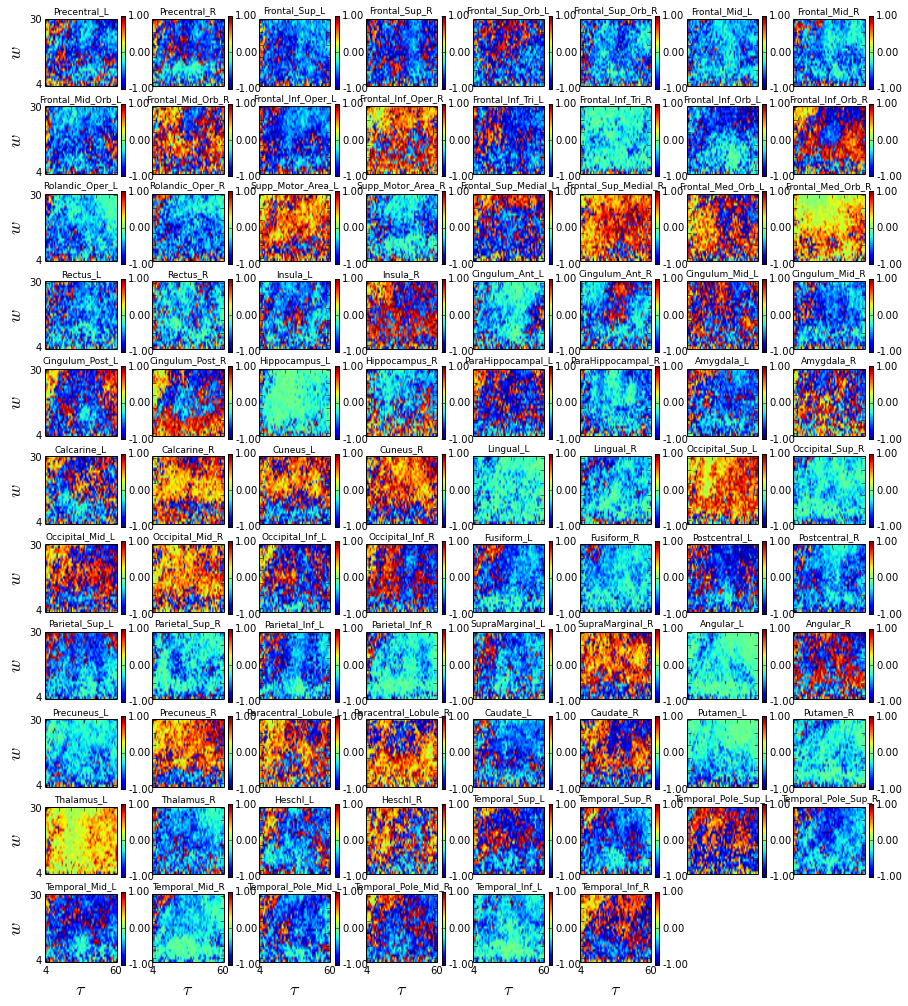

In [92]:
# MAXS
maps(S[0,-1,:,:,:,0], ndS=1)

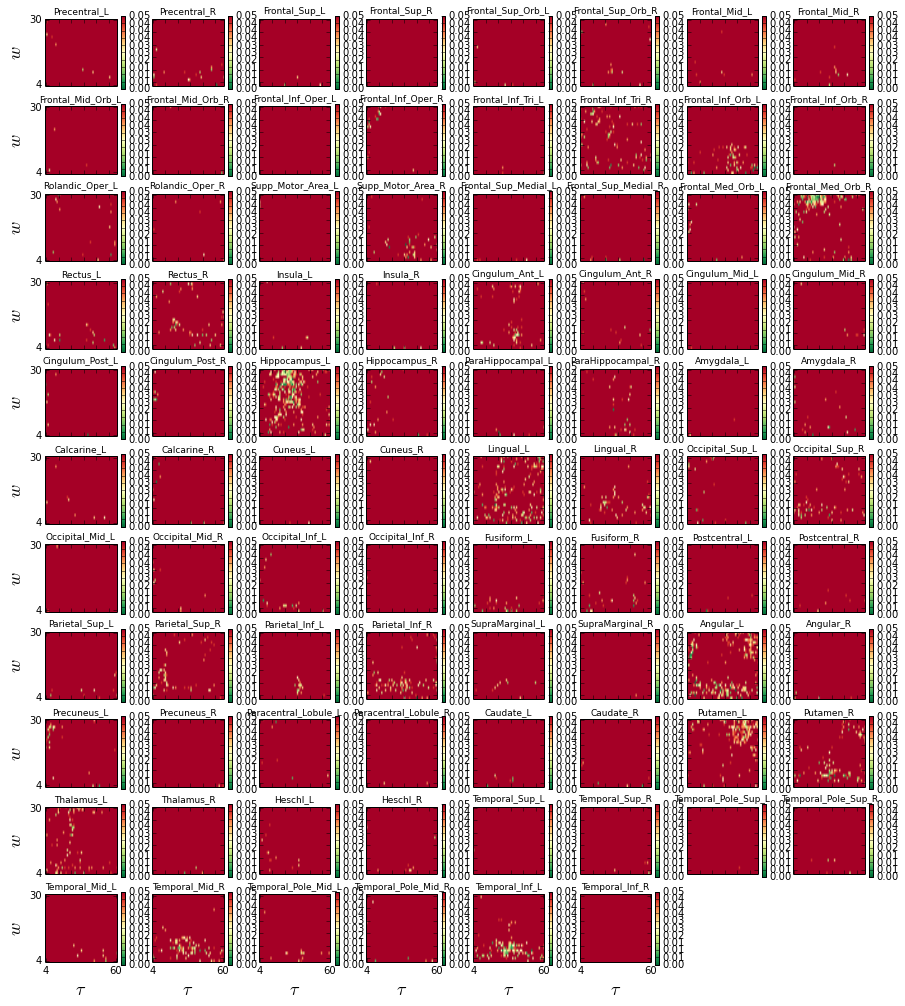

In [14]:
# MAXS
maps(S[0,-1,:,:,:,0], ndS=0)

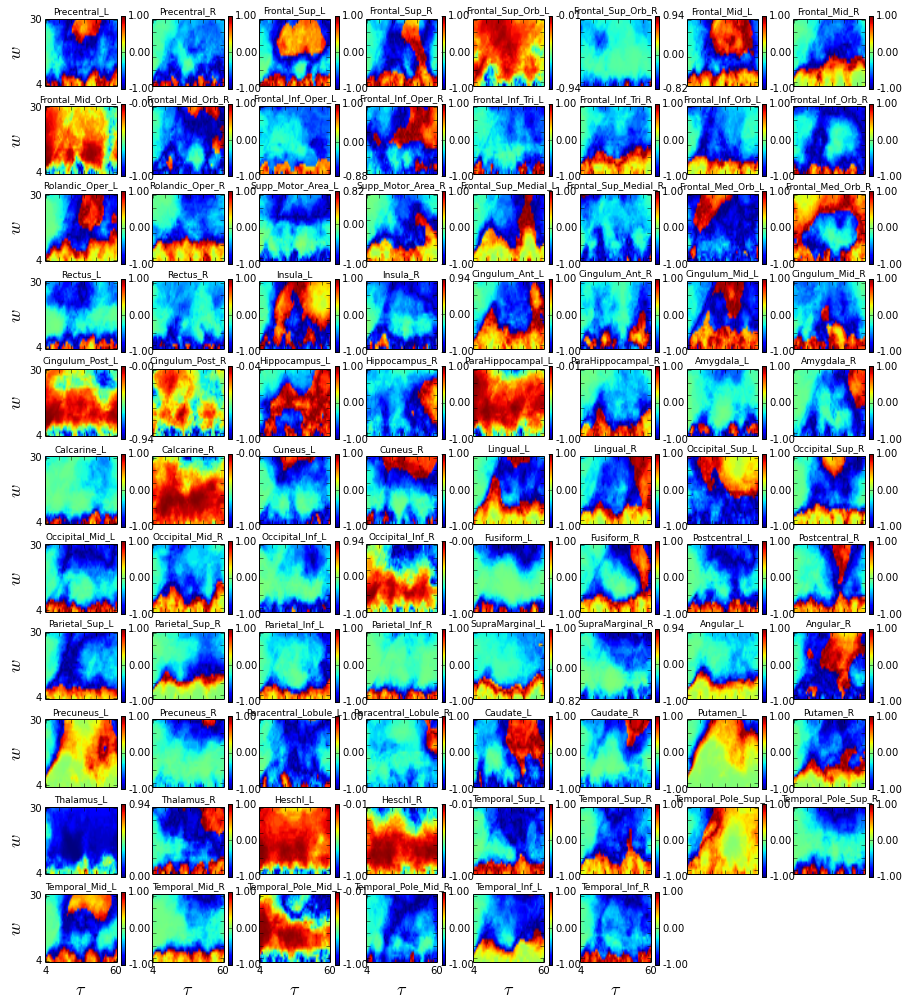

In [94]:
# DEVIATIONS
maps(S[0,-1,:,:,:,1], ndS=1)

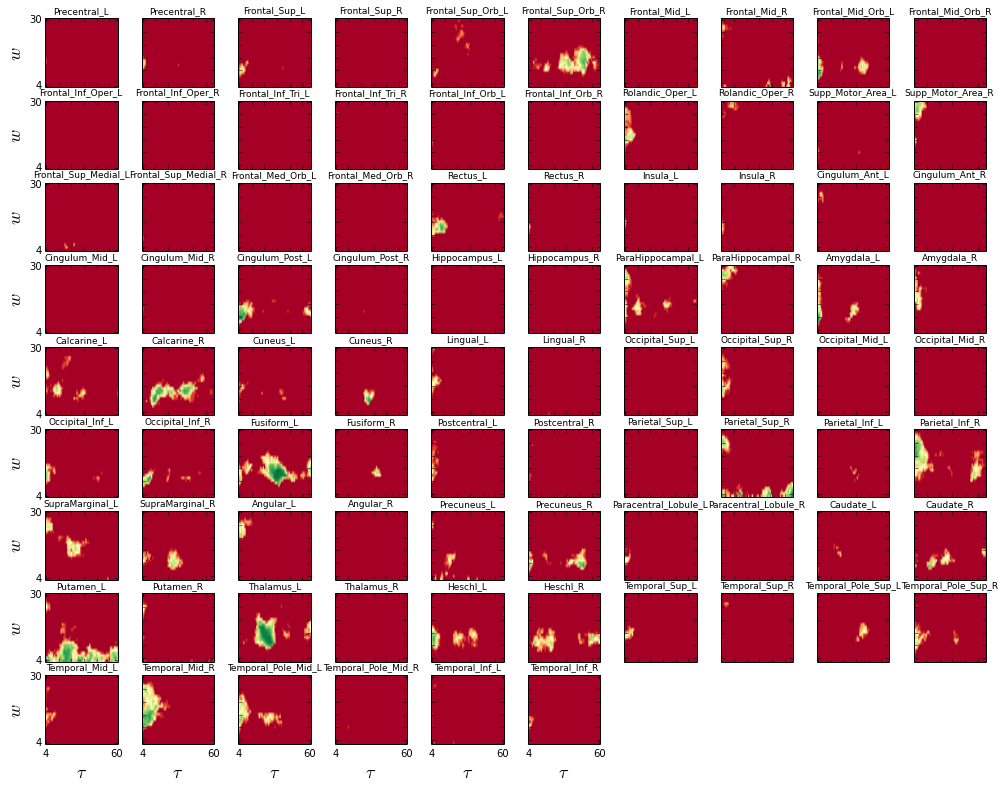

In [11]:
# DEVIATIONS
maps(S[0,-1,:,:,:,1], ndS=0)

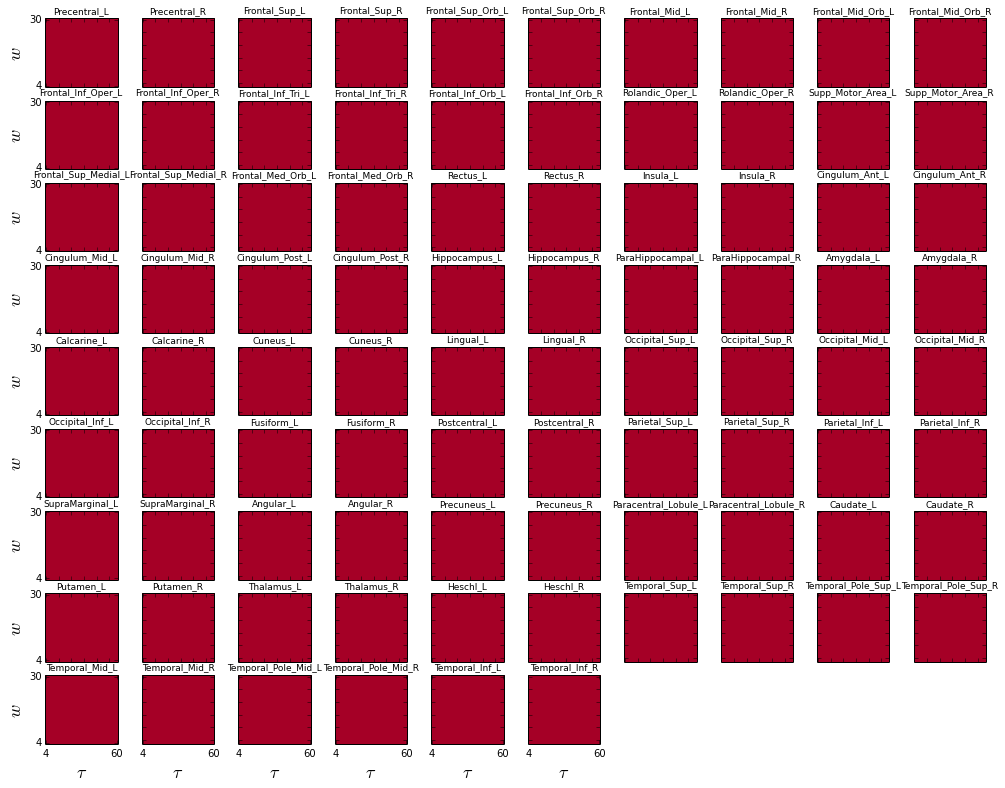

In [10]:
# DEVIATIONS
maps(S[0,-1,:,:,:,1]*86., ndS=0)

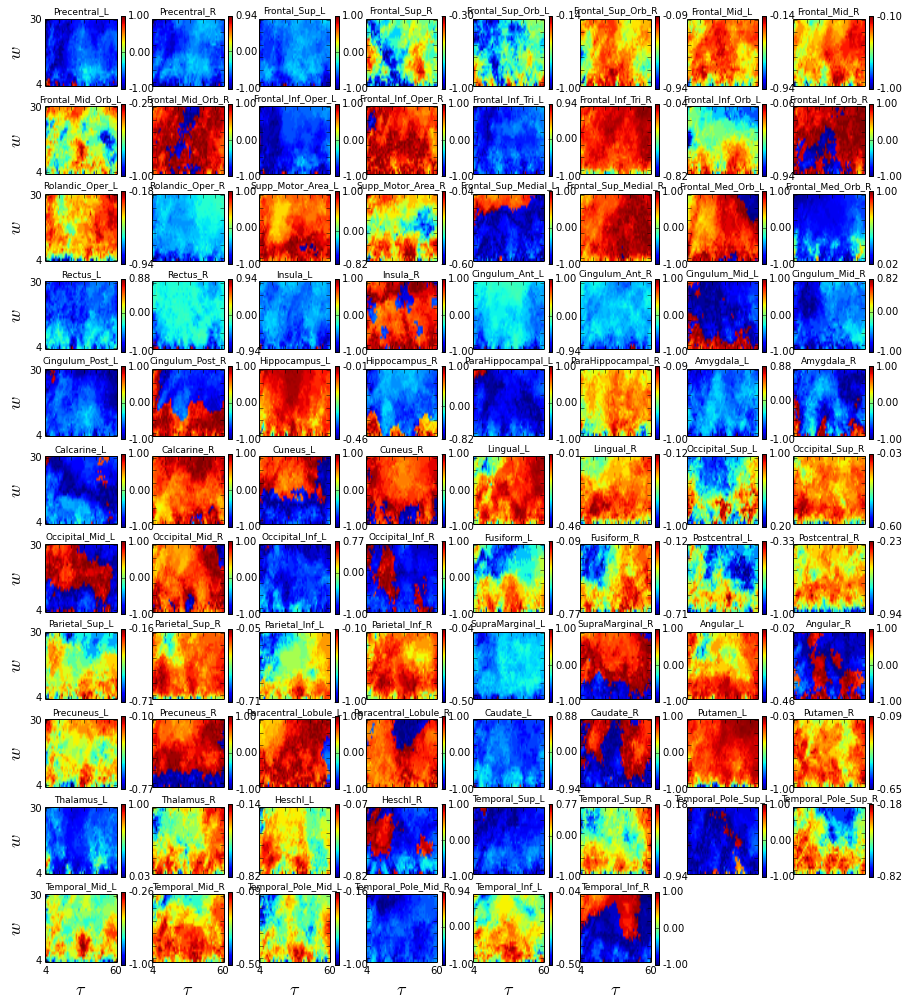

In [96]:
# MEDIANS
maps(S[0,-1,:,:,:,2], ndS=1)

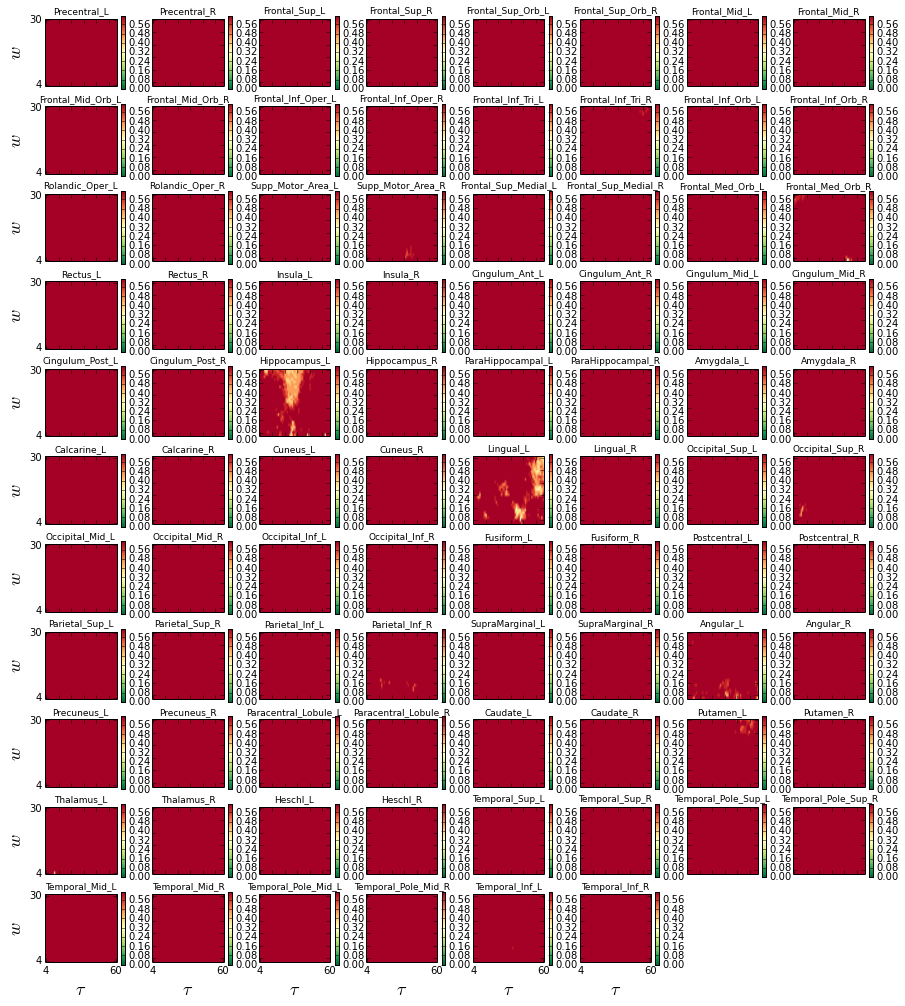

In [148]:
# MEDIANS
maps(S[0,-1,:,:,:,2], ndS=0)

# REGRESSED

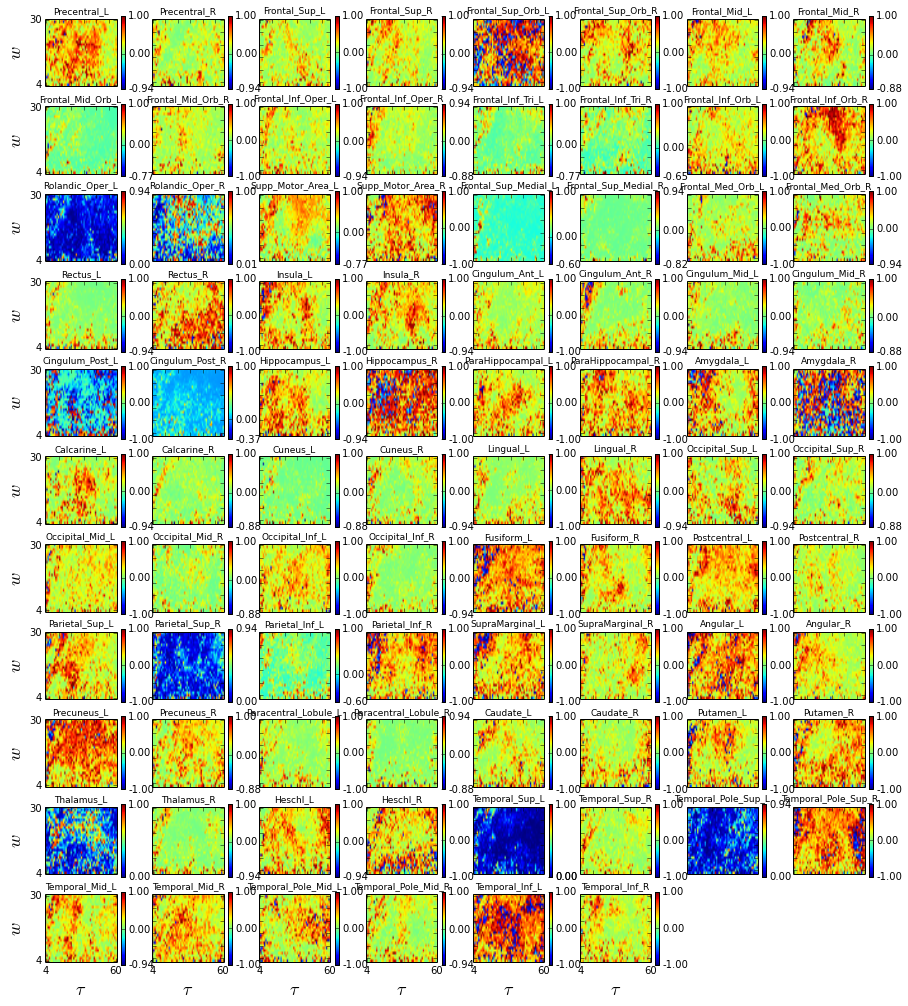

In [98]:
# MAXS
maps(S[1,-1,:,:,:,0], ndS=1)

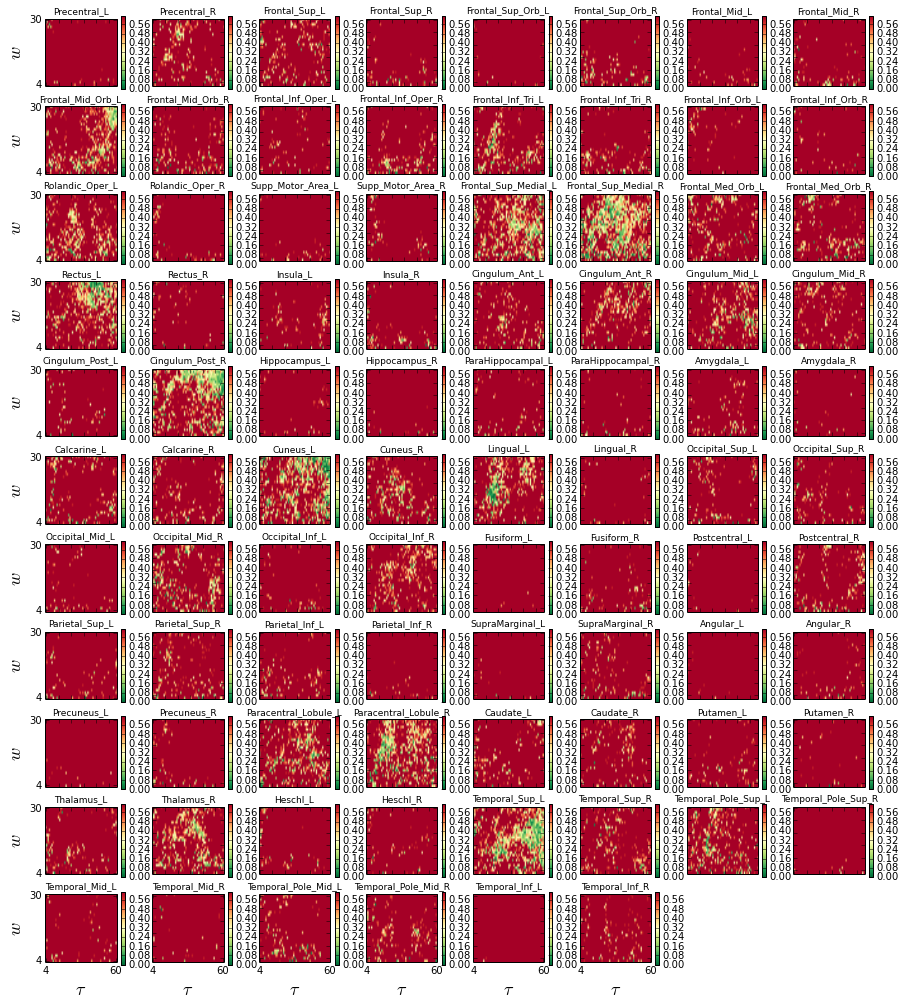

In [145]:
# MAXS
maps(S[1,-1,:,:,:,0], ndS=0)

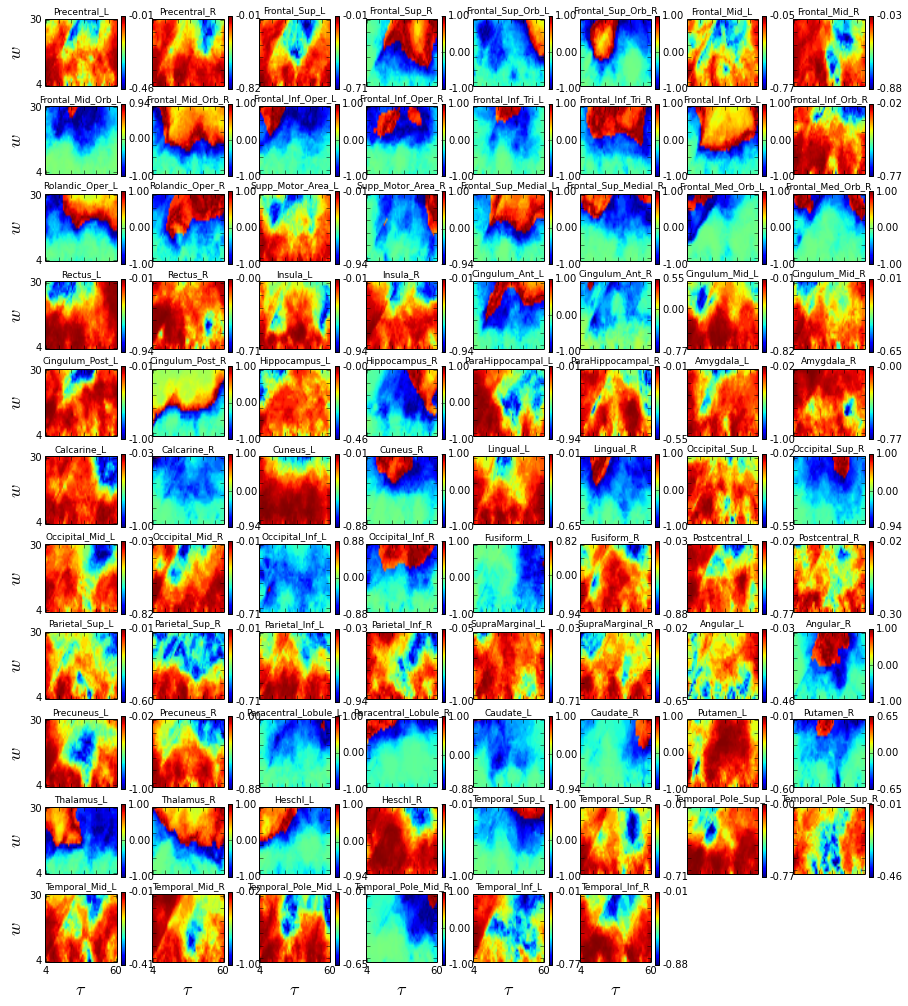

In [100]:
# DEVIATIONS
maps(S[1,-1,:,:,:,1], ndS=1)

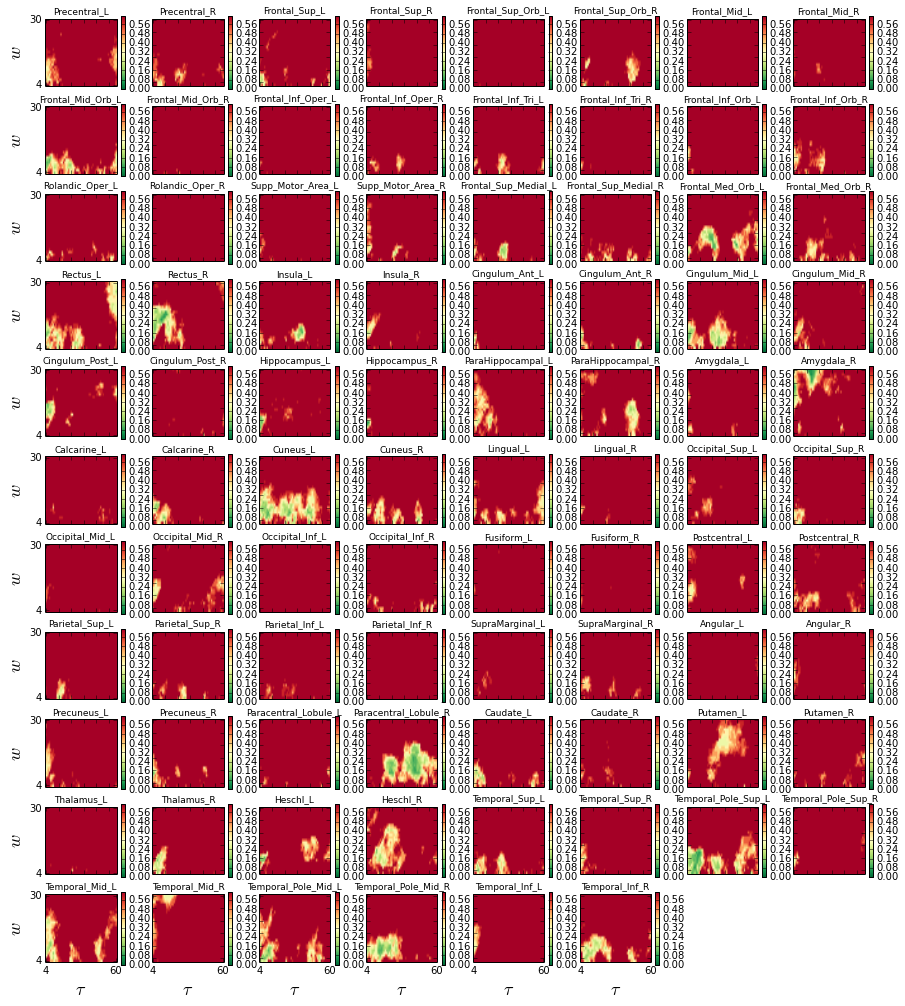

In [144]:
# DEVIATIONS
maps(S[1,-1,:,:,:,1], ndS=0)

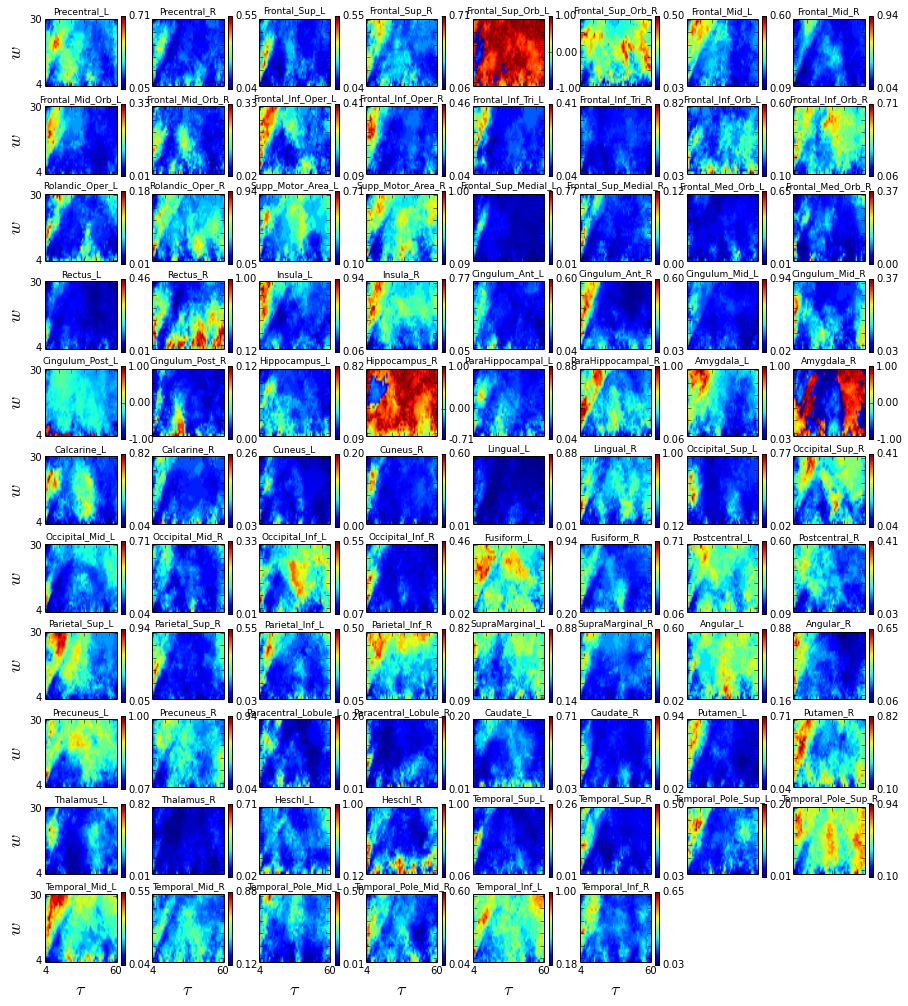

In [102]:
# MEDIANS
maps(S[1,-1,:,:,:,2], ndS=1)

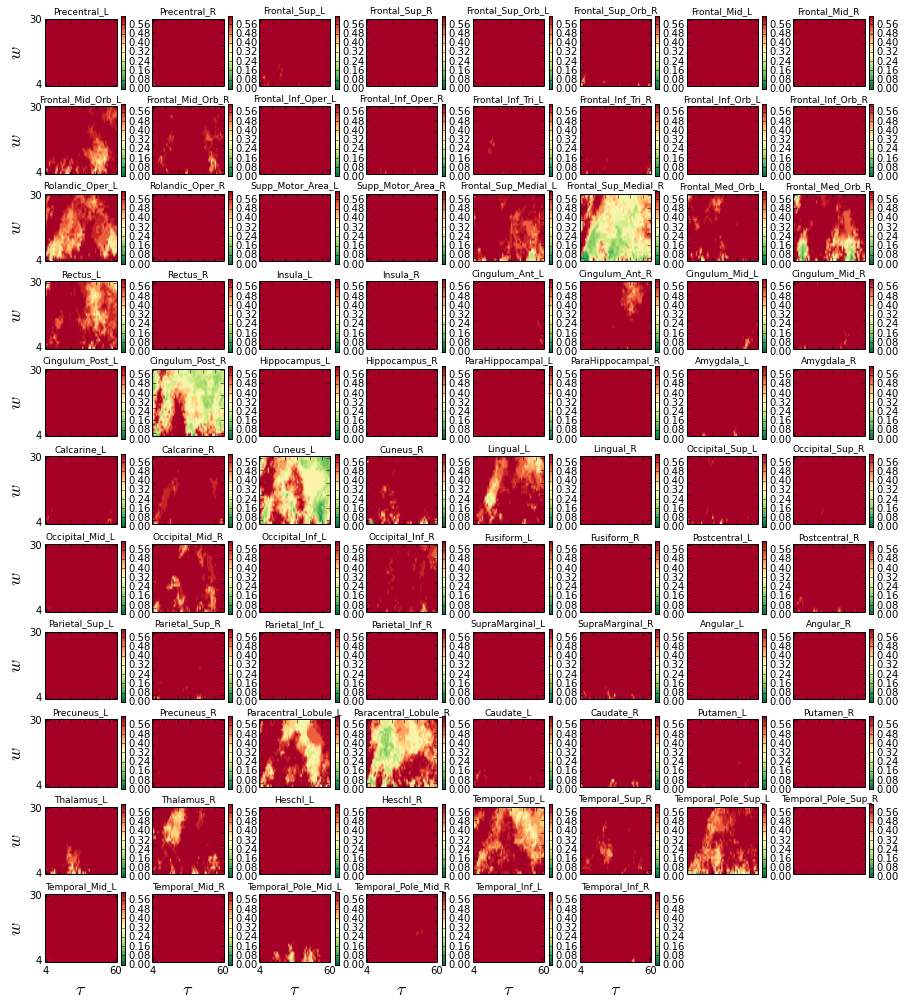

In [149]:
# MEDIANS
maps(S[1,-1,:,:,:,2], ndS=0)